# Data Reduction and Transformation

In [152]:
import transformation_utils as utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import BinaryEncoder
from functools import reduce

In [153]:
df = pd.read_csv("../data/integrated.csv")
target = 'playoff'

## Eliminating Redundant Features 

In [154]:
df.drop(["round", "series", "tmIDWinner", "tmIDLoser", "W_series", "L_series", 'franchID', 'name'], axis=1, inplace=True)

## Feature Engineering

In [155]:
new_df = pd.DataFrame()
for year in df['year'].unique():
    for team in df['tmID'].unique():
        small_df = df[(df['tmID'] == team) & (df['year'] == year)]
        if small_df.empty:
            continue

        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d['award_player'] = (small_df['award_player'].count())
        d['award_coach'] = d['award_coach'].apply(lambda i: 1 if i != 0 else 0)
        d['CBE_Sum'] = (small_df['CBE_Sum'].mean())
        d['height'] = (small_df['height'].mean())
        d['weight'] = (small_df['weight'].mean())
        d['playersAge'] = (2000 + df['year']) - utils.get_overall_age(small_df['birthDate'])
        d.drop('playerID', axis=1, inplace=True)
        d.drop('birthDate', axis=1, inplace=True)

        new_df = pd.concat([new_df, d])

df = new_df.sort_values(by=['year', 'tmID'])

In [156]:
mapping = {'L': 1,
           'W': 1,
           'N': 0}

df['semis'] = df['semis'].map(mapping)
df['finals'] = df['finals'].map(mapping)
df['firstRound'] = df['firstRound'].map(mapping)

## Manual Feature Selection

In [157]:
utils.print_columns(df)
df.drop(['attend', 'arena'], axis=1, inplace=True)
df.drop(['awayL', 'confL', "homeL", "d_oreb", "d_dreb", "o_oreb", "o_dreb", "L_team_post", "lost_team"], axis=1, inplace=True)
df.columns

[ year, tmID, W_team_post, L_team_post, confID, rank, playoff, firstRound, semis, finals, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won_team, lost_team, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, arena, coachID, stint, won_coach, lost_coach, post_wins, post_losses, CBE_Sum, height, weight, award_player, award_coach, playersAge ]


Index(['year', 'tmID', 'W_team_post', 'confID', 'rank', 'playoff',
       'firstRound', 'semis', 'finals', 'o_fgm', 'o_fga', 'o_ftm', 'o_fta',
       'o_3pm', 'o_3pa', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk',
       'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_reb',
       'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won_team', 'GP',
       'homeW', 'awayW', 'confW', 'min', 'coachID', 'stint', 'won_coach',
       'lost_coach', 'post_wins', 'post_losses', 'CBE_Sum', 'height', 'weight',
       'award_player', 'award_coach', 'playersAge'],
      dtype='object')

In [158]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# Define weights for each statistic
w1, w2, w3, w4 = 1, 0.8, 0.5, 0.7  # Adjust these weights based on your preferences

# Calculate ATR for each row
df['ATR'] = (w1 * (df['o_pts']) - df['d_pts']) + (w2 * (df['o_reb'] - df['d_reb'])) + (w3 * (df['o_asts'] - df['d_asts'])) + (w4 * (df['o_fgm'] - df['d_fgm']))

df.drop(['o_pts', 'o_reb', 'o_asts', 'o_fgm', 'd_pts', 'd_reb', 'd_asts', 'd_fgm'], axis=1, inplace=True)

## Feature Encoding

In [159]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
df['confID'] = le.fit_transform(df['confID'])

nominal_cols = ['tmID', 'coachID']
encoder = BinaryEncoder(cols = nominal_cols)
df = encoder.fit_transform(df)

key_cols = ['confID', 'year', 'firstRound', 'semis', 'finals', 'playoff']
nominal_cols = [col for col in df.columns if any (map(lambda x: x in col, nominal_cols))]
excluded_cols = nominal_cols + key_cols

numerical_cols = list(set(df.columns) - set(excluded_cols))

## Feature Scaling

In [160]:
scaler = RobustScaler()
normalizer = MinMaxScaler()

df[numerical_cols] = scaler.fit_transform(df.drop(excluded_cols, axis=1))
df[numerical_cols] = normalizer.fit_transform(df.drop(excluded_cols, axis=1))
df.head()

,year,tmID_0,tmID_1,tmID_2,tmID_3,tmID_4,W_team_post,confID,rank,playoff,...,lost_coach,post_wins,post_losses,CBE_Sum,height,weight,award_player,award_coach,playersAge,ATR
85,2,0,0,0,0,1,0.557377,0,0.166667,1,...,0.209581,0.0,0.303183,0.232323,0.440079,0.321429,0.292537,0.262097,0.384279,0.000000
169,2,0,0,0,1,0,0.284836,0,0.541667,1,...,0.431138,0.0,0.338358,0.136364,0.261297,0.607143,0.277612,0.395161,0.567686,0.428571
337,2,0,0,0,1,1,0.426230,0,0.416667,0,...,0.437126,0.0,0.113903,0.222222,0.385069,0.000000,0.555224,0.383065,0.532751,0.000000
165,2,0,0,1,0,0,0.131148,1,0.958333,1,...,0.580838,0.0,0.479062,0.161616,0.706376,0.964286,0.561194,0.410557,0.139738,0.857143
228,2,0,0,1,0,1,0.461066,0,0.208333,0,...,0.502994,0.0,0.529313,0.085859,0.329001,0.000000,0.283582,0.415633,0.480349,0.000000


## Feature Selection

In [161]:
initial = df.columns
df = utils.select_features(df, target, excluded_cols)

print("Removed: ", set(initial) - set(df.columns))

Removed:  {'o_pf', 'W_team_post', 'award_coach', 'lost_coach', 'playersAge'}


In [162]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


In [163]:
df.columns

Index(['tmID_4', 'o_3pm', 'd_fga', 'd_3pm', 'CBE_Sum', 'o_to', 'ATR',
       'firstRound', 'd_3pa', 'tmID_0', 'coachID_4', 'homeW', 'tmID_3',
       'confW', 'confID', 'finals', 'o_fga', 'won_coach', 'coachID_1',
       'height', 'weight', 'o_ftm', 'coachID_3', 'year', 'post_losses',
       'playoff', 'd_to', 'o_3pa', 'GP', 'min', 'post_wins', 'won_team',
       'coachID_2', 'tmID_1', 'coachID_0', 'o_blk', 'o_fta', 'd_stl', 'd_fta',
       'd_pf', 'rank', 'stint', 'award_player', 'awayW', 'tmID_2', 'o_stl',
       'd_ftm', 'semis', 'coachID_5', 'd_blk'],
      dtype='object')

## Feature Aggregation

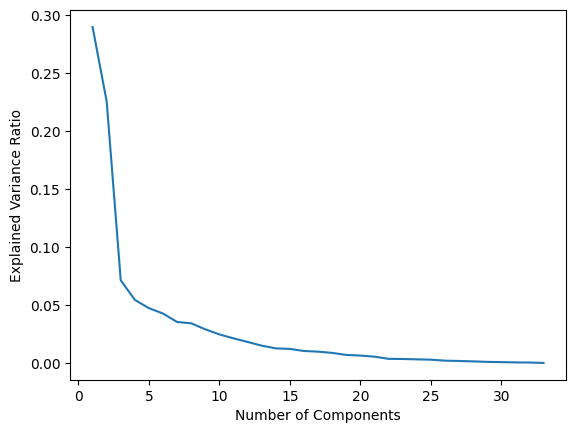

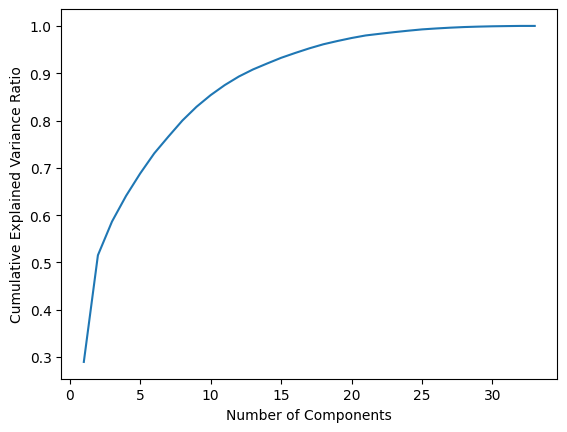

In [164]:
utils.plot_pca(df.drop(excluded_cols, axis=1))

In [165]:
n_components = 8
old_df = df.copy()
df = utils.feature_aggregation_pca(df, n_components, excluded_cols)
utils.print_columns(df)

[ PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, tmID_0, tmID_1, tmID_2, tmID_3, tmID_4, coachID_0, coachID_1, coachID_2, coachID_3, coachID_4, coachID_5, confID, year, firstRound, semis, finals, playoff ]


## Checking for Correlation

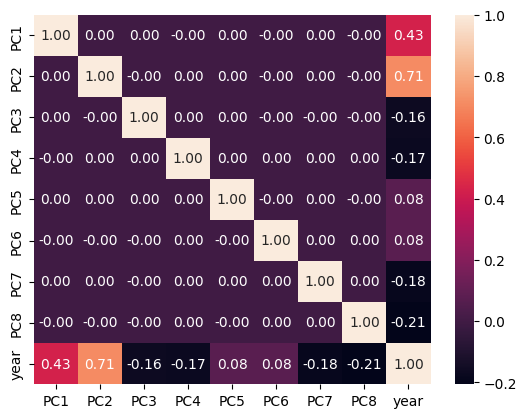

<Figure size 14400x14400 with 0 Axes>

In [166]:
excluded_cols.remove("year")
utils.plot_correlation(df.drop(excluded_cols, axis=1))


## Checking for null values

In [167]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


# Saving the data

In [168]:
df.to_csv("../data/transformed.csv", index=False)